In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, Conv2D, ReLU, BatchNormalization, Add, GlobalAveragePooling2D,
    Dense, Flatten, Multiply, Dropout, MaxPooling2D, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [3]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [4]:
X = np.array(image_paths)
y = np.array(age_labels)

In [5]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, target_size=(128, 128))
        img = img_to_array(img)
        features.append(img)
    return np.array(features)

In [6]:
X = extract_features(image_paths)

In [7]:
X /= 255.0

In [8]:
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.5, random_state=42)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [10]:
def attention_module(input_tensor):
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Attention map
    return x

In [11]:
def patch_cnn(input_tensor, attention_map):
    # Multiply attention map with input to focus on relevant regions
    attended_features = Multiply()([input_tensor, attention_map])

    # Process attended features with additional convolutional layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(attended_features)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    return x

In [12]:
def attention_vgg16_model(input_shape):
    inputs = Input(shape=input_shape)

    # Pretrained VGG16 backbone
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Attention mechanism ("Where")
    attention_map = attention_module(vgg16_base.output)

    # Patch CNN ("What")
    patch_features = patch_cnn(vgg16_base.output, attention_map)

    # Global features from VGG16
    global_features = GlobalAveragePooling2D()(vgg16_base.output)

    # Combine features
    combined_features = Concatenate()([global_features, patch_features])

    # MLP Classifier
    x = Dense(256, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression output for age

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the model
model = attention_vgg16_model((128, 128, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# # VGG16-based model
# def VGG16_model(input_shape):
#     base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#     for layer in base_model.layers:
#         layer.trainable = False

#     x = base_model.output
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(1, activation='linear')(x)

#     model = Model(inputs=base_model.input, outputs=outputs)
#     return model

# model = VGG16_model((128, 128, 3))

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [16]:
# Callbacks
model_save_path = '/kaggle/working/vgg16_model.keras'
model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [17]:
# Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 89s 128ms/step - loss: 253.4636 - mae: 11.6698 - val_loss: 131.9864 - val_mae: 8.5907 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 160.7135 - mae: 9.4454 - val_loss: 135.3129 - val_mae: 8.3518 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 148.0843 - mae: 8.9344 - val_loss: 132.2253 - val_mae: 8.5011 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - loss: 137.3285 - mae: 8.6119 - val_loss: 134.2343 - val_mae: 8.3909 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - loss: 128.9800 - mae: 8.2946 - val_loss: 120.7188 - val_mae: 8.0131 - learning_rate: 5.0000e-04
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 67s 112ms/step - loss: 127.6854 - mae: 8.2551 - val_loss: 107.0437 - val_mae: 7.3389 - learning_rate: 5.0000e-04
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 111ms/step - loss: 127.0539 - mae: 8.2157 - val_loss: 110.

In [18]:
# Load the best model
model = tf.keras.models.load_model('/kaggle/working/vgg16_model.keras')

In [19]:
# Evaluation
loss, mae = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Regression Mean Squared Error (MSE): {loss:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 86.7136 - mae: 6.7316
Regression Mean Squared Error (MSE): 90.6539
Regression Mean Absolute Error (MAE): 6.8758


In [20]:
# Predictions
y_pred = model.predict(X_test, verbose=1)

# Metrics Calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
Regression Mean Squared Error (MSE): 90.6539
Regression Mean Absolute Error (MAE): 6.8758
Regression R² Score: 0.7766


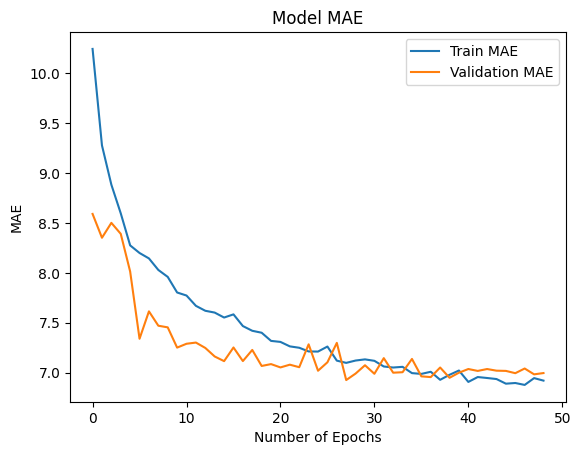

In [21]:
# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

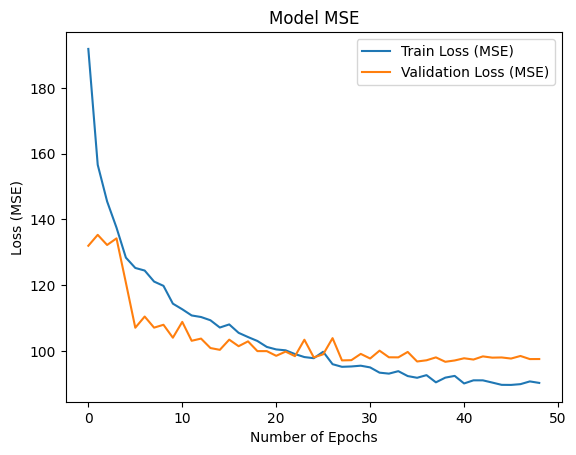

In [22]:
# Plot Loss (MSE)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()